### Основное задание

Возьмите датасет https://www.kaggle.com/ajayrana/hymenoptera-data/kernels   
1.Обучите на нем модели ResNet 18 и VGG 16 с нуля (5-10 эпох)   
2.Обучите на нем модели ResNet 18 и VGG 16 с использованием FineTuning (5-10 эпох)   
3.Добавьте аугментацию данных к пункту 2  

Сравните качество всех 3 полученных подходов


In [1]:
import torch
from torch import nn
import torchvision as tv
import time
import os
import matplotlib.pyplot as plt
import numpy as np
from  itertools import tee #dataloaders = tee(dataloaders, n=2)

In [2]:
PATH_TO_DATA= '../data/hymenoptera_data/'

In [3]:
transforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((224,224)),
    tv.transforms.ToTensor()
])

In [4]:
image_datasets = {x: tv.datasets.ImageFolder(root=os.path.join(PATH_TO_DATA, x), transform=transforms)
                  for x in ['train', 'val'] }
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8, shuffle=True, num_workers=4)
              for x in ['train', 'val']}

In [6]:
class_names = image_datasets['train'].classes
print(f'class_names : {class_names}')

class_names : ['ants', 'bees']


In [7]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = torch.Tensor([0]), 0
    net.eval()
    for X, y in data_iter:
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [8]:
def train(net, train_iter, test_iter, trainer, num_epochs):
    loss = nn.CrossEntropyLoss(reduction='sum')
    net.train()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            trainer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]
            print("Step. time since epoch: {:.3f}. Train acc: {:.3f}. Train Loss: {:.3f}".format(time.time() -  start,
                (y_hat.argmax(axis=1) == y).sum().item() / y.shape[0], l.item()))
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc,
                 time.time() - start))

In [9]:
# Создадим удобную обертку для использования в дальнейшем

In [10]:
def get_model(model_type, pretrained=False):
    ''' Return model and param list to be updated '''
    assert model_type == tv.models.resnet18 or model_type == tv.models.vgg16_bn, 'Unsupported model type'
    
    if pretrained == False:
        model = model_type(pretrained)
        return model, model.parameters()
    else:
        model = model_type(pretrained)
        # Убираем требование градиента:
        for param in model.parameters():
            param.requires_grad = False
        
        # Пересоздадим финальный слой 
        if model_type == tv.models.resnet18:
            model.fc = nn.Linear(in_features=model.fc.in_features, out_features=model.fc.out_features) 
            print(f'model.fc : {model.fc}')
        elif model_type == tv.models.vgg16_bn:
            model.classifier = nn.Sequential(
                nn.Linear(in_features=25088, out_features=4096, bias=True),
                nn.ReLU(inplace=True),
                nn.Dropout(p=0.5, inplace=False),
                nn.Linear(in_features=4096, out_features=4096, bias=True),
                nn.ReLU(inplace=True),
                nn.Dropout(p=0.5, inplace=False),
                nn.Linear(in_features=4096, out_features=1000, bias=True)
            )
            print(f'model.classifier : {model.classifier}')
        
        # Получим имена параметров для обновления 
        print("Params to learn:")
        params_to_update = []
        for name, param in model.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t",name)
                
        return model, params_to_update        

### 1.Обучение ResNet 18 и VGG 16 с нуля (5-10 эпох)   

In [11]:
resnet18_model, params_to_update = get_model(tv.models.resnet18, pretrained=False)

In [12]:
lr, num_epochs = 0.001, 5
trainer = torch.optim.SGD(params_to_update, lr=lr)
#trainer = torch.optim.Adam(model.parameters(), lr=lr)
train(resnet18_model, dataloaders['train'], dataloaders['val'], trainer, num_epochs)

Step. time since epoch: 7.990. Train acc: 0.000. Train Loss: 53.523
Step. time since epoch: 9.176. Train acc: 0.500. Train Loss: 42.671
Step. time since epoch: 10.424. Train acc: 0.500. Train Loss: 33.270
Step. time since epoch: 11.606. Train acc: 0.250. Train Loss: 27.626
Step. time since epoch: 12.897. Train acc: 0.500. Train Loss: 19.432
Step. time since epoch: 14.063. Train acc: 0.750. Train Loss: 14.050
Step. time since epoch: 15.305. Train acc: 0.500. Train Loss: 12.336
Step. time since epoch: 16.467. Train acc: 0.625. Train Loss: 8.120
Step. time since epoch: 17.668. Train acc: 0.375. Train Loss: 9.709
Step. time since epoch: 18.907. Train acc: 0.250. Train Loss: 11.352
Step. time since epoch: 20.114. Train acc: 0.750. Train Loss: 5.713
Step. time since epoch: 21.338. Train acc: 0.625. Train Loss: 6.566
Step. time since epoch: 22.650. Train acc: 0.625. Train Loss: 5.333
Step. time since epoch: 24.157. Train acc: 0.625. Train Loss: 6.108
Step. time since epoch: 25.674. Train acc:

In [21]:
# Доля правильных ответов при использовании resnet18 получилось не очень высоким - около 0.5

In [57]:
vgg16_model, params_to_update = get_model(tv.models.vgg16_bn, pretrained=False)

In [18]:
lr, num_epochs = 0.001, 5
trainer = torch.optim.SGD(params_to_update, lr=lr)
train(vgg16_model, dataloaders['train'], dataloaders['val'], trainer, num_epochs)

Step. time since epoch: 13.810. Train acc: 0.000. Train Loss: 49.763
Step. time since epoch: 23.282. Train acc: 0.500. Train Loss: 67.651
Step. time since epoch: 32.860. Train acc: 0.500. Train Loss: 21.865
Step. time since epoch: 41.570. Train acc: 0.375. Train Loss: 52.008
Step. time since epoch: 50.366. Train acc: 0.750. Train Loss: 18.758
Step. time since epoch: 59.822. Train acc: 0.500. Train Loss: 9.867
Step. time since epoch: 69.325. Train acc: 0.625. Train Loss: 15.843
Step. time since epoch: 78.711. Train acc: 0.625. Train Loss: 18.025
Step. time since epoch: 88.016. Train acc: 0.375. Train Loss: 33.434
Step. time since epoch: 97.081. Train acc: 0.250. Train Loss: 74.125
Step. time since epoch: 106.687. Train acc: 0.625. Train Loss: 17.706
Step. time since epoch: 115.570. Train acc: 0.375. Train Loss: 15.642
Step. time since epoch: 124.424. Train acc: 0.500. Train Loss: 23.752
Step. time since epoch: 133.241. Train acc: 0.625. Train Loss: 15.523
Step. time since epoch: 141.794

KeyboardInterrupt: 

### 2. Обучение модели ResNet 18 и VGG 16 с использованием FineTuning (5-10 эпох)   

In [19]:
resnet18_model, params_to_update = get_model(tv.models.resnet18, pretrained=True)

model.fc : Linear(in_features=512, out_features=1000, bias=True)
Params to learn:
	 fc.weight
	 fc.bias


In [20]:
lr, num_epochs = 0.001, 5
trainer = torch.optim.SGD(params_to_update, lr=lr)
train(resnet18_model, dataloaders['train'], dataloaders['val'], trainer, num_epochs)

Step. time since epoch: 7.688. Train acc: 0.000. Train Loss: 55.078
Step. time since epoch: 8.252. Train acc: 0.000. Train Loss: 44.466
Step. time since epoch: 8.874. Train acc: 0.375. Train Loss: 33.014
Step. time since epoch: 9.484. Train acc: 0.500. Train Loss: 20.620
Step. time since epoch: 9.982. Train acc: 0.500. Train Loss: 12.443
Step. time since epoch: 10.490. Train acc: 0.625. Train Loss: 9.506
Step. time since epoch: 11.098. Train acc: 0.375. Train Loss: 8.981
Step. time since epoch: 11.756. Train acc: 0.625. Train Loss: 7.284
Step. time since epoch: 12.398. Train acc: 0.875. Train Loss: 6.304
Step. time since epoch: 13.039. Train acc: 0.500. Train Loss: 6.281
Step. time since epoch: 13.665. Train acc: 0.750. Train Loss: 5.235
Step. time since epoch: 14.296. Train acc: 0.250. Train Loss: 8.642
Step. time since epoch: 14.923. Train acc: 0.625. Train Loss: 5.393
Step. time since epoch: 15.549. Train acc: 1.000. Train Loss: 2.926
Step. time since epoch: 16.189. Train acc: 0.750

In [ ]:
# Предобученная сетка дает потрясающие результаты - 0.951

In [20]:
vgg16_model, params_to_update = get_model(tv.models.vgg16_bn, pretrained=True)

model.classifier : Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)
Params to learn:
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias


In [21]:
lr, num_epochs = 0.001, 5
trainer = torch.optim.SGD(params_to_update, lr=lr)
train(vgg16_model, dataloaders['train'], dataloaders['val'], trainer, num_epochs)

Step. time since epoch: 9.267. Train acc: 0.000. Train Loss: 55.214
Step. time since epoch: 12.076. Train acc: 0.125. Train Loss: 54.631
Step. time since epoch: 14.961. Train acc: 0.375. Train Loss: 53.647
Step. time since epoch: 18.649. Train acc: 0.625. Train Loss: 53.001
Step. time since epoch: 22.582. Train acc: 0.625. Train Loss: 52.670
Step. time since epoch: 26.577. Train acc: 0.625. Train Loss: 52.132
Step. time since epoch: 30.588. Train acc: 0.625. Train Loss: 50.964
Step. time since epoch: 34.641. Train acc: 0.625. Train Loss: 49.780
Step. time since epoch: 38.594. Train acc: 0.500. Train Loss: 49.642
Step. time since epoch: 42.745. Train acc: 0.250. Train Loss: 49.476
Step. time since epoch: 46.674. Train acc: 0.375. Train Loss: 47.531
Step. time since epoch: 50.395. Train acc: 0.250. Train Loss: 46.443
Step. time since epoch: 54.217. Train acc: 0.375. Train Loss: 44.167
Step. time since epoch: 57.943. Train acc: 0.625. Train Loss: 41.982
Step. time since epoch: 61.641. Tra

In [22]:
# Модель VGG долго тренируется, но качество получается выше по сравнению с resnet

### 3. Добавление аугментации данных к предыдущему пункту

In [29]:
def show_images(imgs, num_rows, num_cols, scale=2):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i][j].imshow(imgs[i * num_cols + j], cmap='gray')
            axes[i][j].axes.get_xaxis().set_visible(False)
            axes[i][j].axes.get_yaxis().set_visible(False)
    plt.show()

In [30]:
def apply(img, aug, num_rows=2, num_cols=4, scale=2):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    show_images(Y, num_rows, num_cols, scale)

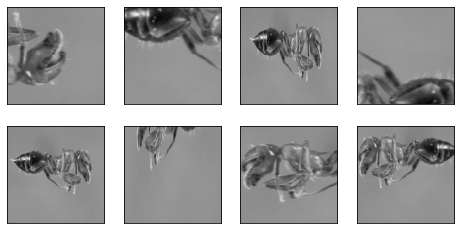

In [35]:
augs = tv.transforms.Compose([
    tv.transforms.ToPILImage(), # важно, так как работаем с тензором
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.RandomVerticalFlip(),
    tv.transforms.RandomResizedCrop( (200, 200), scale=(0.1, 1), ratio=(0.5, 2))])

img = image_datasets['train'][0][0]
apply(img, augs)

In [36]:
resnet18_model, params_to_update = get_model(tv.models.resnet18, pretrained=True)

model.fc : Linear(in_features=512, out_features=1000, bias=True)
Params to learn:
	 fc.weight
	 fc.bias


In [38]:
transforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((224,224)),
    #tv.transforms.ToPILImage(), # важно, так как работаем с тензором
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.RandomVerticalFlip(),
    tv.transforms.RandomResizedCrop( (200, 200), scale=(0.1, 1), ratio=(0.5, 2)),
    tv.transforms.ToTensor()
])

In [39]:
image_datasets = {x: tv.datasets.ImageFolder(root=os.path.join(PATH_TO_DATA, x), transform=transforms)
                  for x in ['train', 'val'] }
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8, shuffle=True, num_workers=4)
              for x in ['train', 'val']}

In [40]:
lr, num_epochs = 0.001, 5
trainer = torch.optim.SGD(params_to_update, lr=lr)
train(resnet18_model, dataloaders['train'], dataloaders['val'], trainer, num_epochs)

Step. time since epoch: 7.534. Train acc: 0.000. Train Loss: 61.939
Step. time since epoch: 7.944. Train acc: 0.000. Train Loss: 46.987
Step. time since epoch: 8.354. Train acc: 0.250. Train Loss: 32.984
Step. time since epoch: 8.774. Train acc: 0.500. Train Loss: 23.018
Step. time since epoch: 9.217. Train acc: 0.625. Train Loss: 13.758
Step. time since epoch: 9.668. Train acc: 0.625. Train Loss: 10.975
Step. time since epoch: 10.126. Train acc: 0.500. Train Loss: 9.224
Step. time since epoch: 10.572. Train acc: 0.250. Train Loss: 10.789
Step. time since epoch: 11.015. Train acc: 0.500. Train Loss: 7.524
Step. time since epoch: 11.444. Train acc: 0.375. Train Loss: 8.513
Step. time since epoch: 11.866. Train acc: 0.375. Train Loss: 9.684
Step. time since epoch: 12.298. Train acc: 0.500. Train Loss: 8.697
Step. time since epoch: 12.737. Train acc: 0.375. Train Loss: 7.496
Step. time since epoch: 13.174. Train acc: 0.750. Train Loss: 5.619
Step. time since epoch: 13.578. Train acc: 0.25

### Задание со звездочкой
Примените FineTuning ResNet 18 к FashionMnist. Удалось ли увидеть резкое увеличение качества?

In [13]:
BATCH_SIZE=256

In [14]:
transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((224,224)),
    tv.transforms.ToTensor()
])

train_dataset = tv.datasets.FashionMNIST('../data/', train=True, transform=transoforms, download=True)
test_dataset = tv.datasets.FashionMNIST('../data/', train=False, transform=transoforms, download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

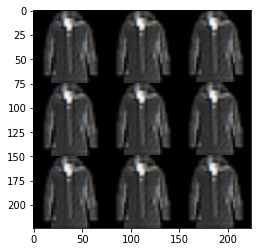

In [15]:
plt.imshow(train_dataset[19][0].numpy().reshape(224,224, 3), cmap='gray')

In [16]:
resnet18_model, params_to_update = get_model(tv.models.resnet18, pretrained=True)

model.fc : Linear(in_features=512, out_features=1000, bias=True)
Params to learn:
	 fc.weight
	 fc.bias


In [17]:
lr, num_epochs = 0.001, 5
trainer = torch.optim.SGD(params_to_update, lr=lr)
train(resnet18_model, train_iter, test_iter, trainer, num_epochs)

Step. time since epoch: 13.263. Train acc: 0.000. Train Loss: 1762.181
Step. time since epoch: 29.249. Train acc: 0.285. Train Loss: 584.532
Step. time since epoch: 45.420. Train acc: 0.305. Train Loss: 1847.147
Step. time since epoch: 62.117. Train acc: 0.293. Train Loss: 2889.394
Step. time since epoch: 79.066. Train acc: 0.191. Train Loss: 4490.512
Step. time since epoch: 96.292. Train acc: 0.238. Train Loss: 4255.340
Step. time since epoch: 114.215. Train acc: 0.180. Train Loss: 4802.231
Step. time since epoch: 131.760. Train acc: 0.309. Train Loss: 4413.472
Step. time since epoch: 149.492. Train acc: 0.297. Train Loss: 3825.153
Step. time since epoch: 167.223. Train acc: 0.324. Train Loss: 3932.660
Step. time since epoch: 184.692. Train acc: 0.156. Train Loss: 3637.403
Step. time since epoch: 201.998. Train acc: 0.332. Train Loss: 3458.850
Step. time since epoch: 219.362. Train acc: 0.426. Train Loss: 3223.282
Step. time since epoch: 237.157. Train acc: 0.383. Train Loss: 3690.096

KeyboardInterrupt: 

Резкого увеличения качества увидеть не удалось. Связываю это с, возможно, не лучшим преобразованием исходного файла на входе